In [60]:
import pyemma
import numpy as np
from glob import glob
from tqdm import tqdm # progress bars
import networkx as nx

# get dtrajs from feature-based clustering
dtrajs_src = np.load('contacts-results/src_10471_dtrajs.npy')
dtrajs_abl = np.load('contacts-results/abl_10472_dtrajs.npy')

## get dtrajs from RMSD
#dtrajs_src = [np.load(f) for f in glob('rmsd_clustering_results/10471/dtrajs/*.npy')]
#dtrajs_abl = [np.load(f) for f in glob('rmsd_clustering_results/10472/dtrajs/*.npy')]

# compute gamma matrix

# version 1
def estimate_gamma_version_1(dtrajs):
    '''
    iniitial implementation of estimator for Gamma
    '''
    
    dtraj_stack = np.hstack(dtrajs)
    n_states = len(set(dtraj_stack))
    
    gamma = np.zeros((n_states,n_states))
    
    for dtraj in tqdm(dtrajs):
        for i in range(n_states):
            indices = list(np.arange(len(dtraj))[dtraj==i]) + [len(dtraj)]
            for t in range(len(indices)-1):
                js = set(dtraj[indices[t]:indices[t+1]])
                for j in (js - set([i])):
                    gamma[i,j] += 1
        
    for i in range(n_states):
        gamma[i] /= np.sum(dtraj_stack==i)
    
    return gamma

# version 2
def find_subsequences(dtraj, i, include_end=True):
    '''
    Splits the dtraj into subsequences that
    1. start with i,
    2. hit at least one state j =/= i before returning to i

    If include_end == True, then we also include

    If include_end == False, we only keep subsequences that have returned to i
        Not implmented yet!

        In the paper, I think they always include_end.


    Returns
    -------
    list of integer arrays

    '''

    if include_end == False:
        raise (NotImplementedError())

    inds = list(np.arange(len(dtraj))[dtraj == i])
    inds.append(len(dtraj))

    subsequences = [dtraj[inds[t]:inds[t + 1]] for t in range(len(inds) - 1)]
    subsequences = [subseq for subseq in subsequences if len(subseq) > 1]
    return subsequences

def estimate_gamma_version_2(dtrajs):
    '''


    Estimates a matrix Gamma, where Gamma[i,j] is the probability that, after leaving `i`,
    you will hit `j` before hitting `i` again.

    This is the "reference" implementation, implemented inefficiently but in a way that's (hopefully) easy to check for correctness.

    Parameters
    ----------
    dtrajs : list of integer arrays
        discrete trajectories, e.g. after assigning to microstates, or trial milestones

    Returns
    -------
    gamma : numpy.ndarray
        square matrix of floats between 0 and 1
        (should this be row-stochastic?)

    '''

    # states are non-negative integers
    assert (np.hstack(dtrajs).min() >= 0)
    n_states = np.max(np.hstack(dtrajs)) + 1

    # matrix we'll store the results
    gamma = np.zeros((n_states, n_states))

    # number of pieces that start in i and hit j
    N_ij = np.zeros((n_states, n_states))

    # number of pieces that start in i
    N_i = np.zeros(n_states)

    # iterate over all dtrajs
    for dtraj in tqdm(dtrajs):
        for i in range(n_states):
            # find subsequences that start in i and hit something else before returning to i
            subsequences = find_subsequences(dtraj, i)

            # increment the count of number of pieces that start in i
            N_i[i] += len(subsequences)

            # for each subsequence, get the set of states visited after i
            sets = [set(subseq[1:]) for subseq in subsequences]
            
            for s in sets:
                for j in s:
                    N_ij[i, j] += 1

    # estimate gamma from N_ij and N_i
    for i in range(n_states):
        for j in range(n_states):
            gamma[i, j] = N_ij[i, j] / N_i[i]

    return gamma

gamma_src = estimate_gamma_version_1(dtrajs_src)
gamma_abl = estimate_gamma_version_1(dtrajs_abl)

100%|██████████| 500/500 [00:17<00:00, 29.13it/s]


In [63]:
def metastability_index_using_comprehensions(gamma, M):
    '''
    possibly buggy, since this is giving infs a lot of the time
    
    numerator = max_{i \in M} (max_{j \in M \minus i} Gamma[i,j])
    denominator = min_{i \not\in M} (max_{j \in M} Gamma[i,j])
    '''
    not_M = set(range(len(gamma))) - set(M)
    M_minus = lambda i:set(M) - set([i])
    
    numerator = max([max([gamma[i,j] for j in M_minus(i)]) for i in M])
    denominator = min([max([gamma[i,j] for j in M]) for i in not_M])
    return numerator / denominator


def metastability_index(gamma,M):
    numerator = 0
    for i in M:
        # maximize over i
        Mprime = set(M) - set([i])
        for j in Mprime:
            # maximize over j
            if gamma[i,j] > numerator:
                numerator = gamma[i,j]
    
    denominators = []
    for i in set(range(len(gamma))) - set(M):
        
        # maximize over j
        denominator = 0
        for j in M:
            if gamma[i,j] > denominator:
                denominator = gamma[i,j]
        
        denominators.append(denominator)
    
    #minimize over i
    denominator = min(denominators)
    
    return numerator / denominator

In [64]:
metastability_index(gamma_src, range(10)), metastability_index(gamma_src, range(400))

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in double_scalars


(inf, inf)

In [65]:
metastability_index(gamma_abl, range(10)), metastability_index(gamma_abl, range(400))

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in double_scalars


(inf, inf)

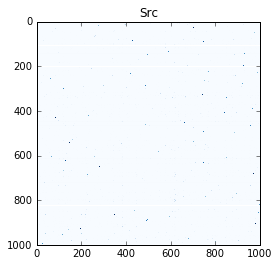

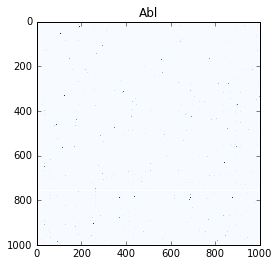

In [8]:
# visually inspect gamma_abl and gamma_src

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(gamma_src, interpolation='none', cmap='Blues')
plt.title('Src')
plt.figure()

plt.imshow(gamma_abl, interpolation='none', cmap='Blues')
plt.title('Abl')

In [9]:
# the gamma matrices look pretty sparse

for (name, matrix) in [('src', gamma_src), ('abl', gamma_abl)]:
    print('{0} : sparsity = {1:.3f}%'.format(name, 100.0 * np.sum(matrix==0) / np.prod(matrix.shape)))

src : sparsity = 95.509%
abl : sparsity = 94.694%


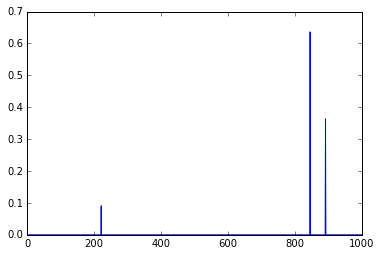

In [10]:
plt.plot(gamma_src[0])

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in double_scalars


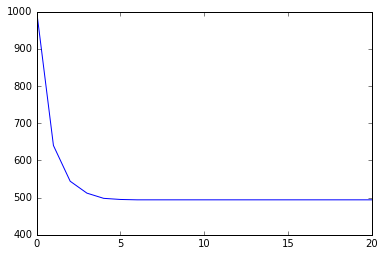

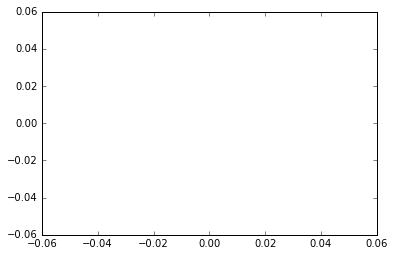

In [97]:
# implement their heuristic optimizer

def get_j_dagger(gamma, i):
    '''
    j_dagger(i) = argmax_{k=/=i} Gamma_ik
    
    eq. 8 : the index of the trial milestone that the trajectory is most likely to hit
    '''
    
    return np.argmax(gamma[i])

def update_M(gamma, M):
    '''
    M --> {j_dagger(i) | i \in M}
    '''
    return set([get_j_dagger(gamma, i) for i in M])

def iterate_M(gamma, init_M, max_iter = 20):
    Ms = [init_M]
    for i in range(max_iter):
        Ms.append(update_M(gamma, Ms[-1]))
    return Ms
        
# example optimization trace:
Ms = iterate_M(gamma_src, init_M = set(range(len(gamma_src))))
plt.plot([len(M) for M in Ms])
plt.figure()
plt.plot([metastability_index(gamma_src, M) for M in Ms[1:]])

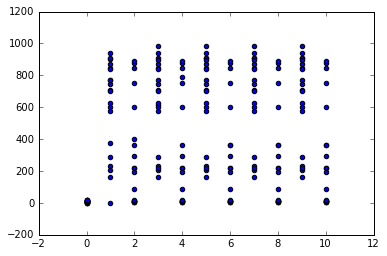

In [16]:
# what does this iteration look like?

inds = np.arange(len(gamma_src))
all_points = []
points = inds[:20]
plt.scatter(np.zeros(len(points)), points)
n_iter = 10
for i in range(n_iter):
    all_points.append(points)
    points = [get_j_dagger(gamma_src, t) for t in points]
    plt.scatter(np.ones(len(points))*(i+1), points)
all_points = np.array(all_points)

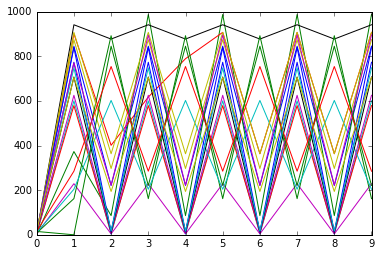

In [17]:
plt.plot(all_points);

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in double_scalars


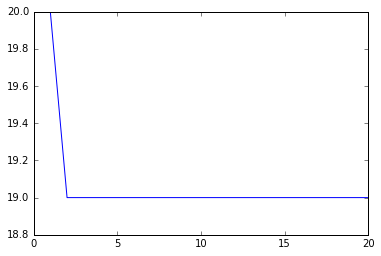

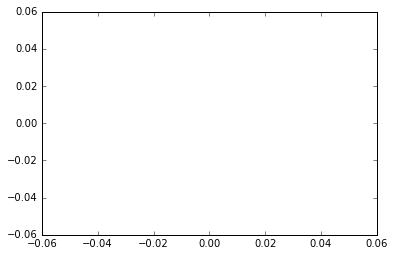

In [98]:
Ms = iterate_M(gamma_src, init_M = set(inds[:20]))
plt.plot([len(M) for M in Ms])
plt.figure()
plt.plot([metastability_index(gamma_src, M) for M in Ms])

 38%|███▊      | 38/100 [00:08<00:12,  4.82it/s]


ZeroDivisionError: integer division or modulo by zero

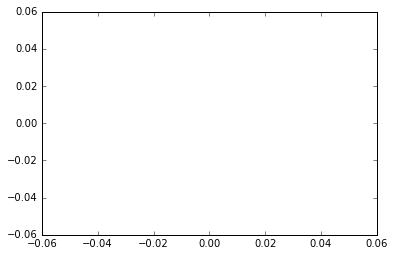

In [99]:
# what do these optimization traces look like?
n_milestones = 20
n_samples = 100

np.random.seed(0)
inds = np.arange(len(gamma_src))

traces = []

for _ in tqdm(range(n_samples)):
    np.random.shuffle(inds)
    Ms = iterate_M(gamma_src, init_M = set(inds[:n_milestones]))
    plt.plot([metastability_index(gamma_src, M) for M in Ms])
    traces.append(Ms)
plt.xlabel('Iteration')
plt.ylabel('Metastability index (lower is better)')
plt.title('Metastability-index optimization trace:\nInitialized 100 times with size-20 milestone sets')

In [ ]:
# what values of this index do we get if we pick milestones uniformly at random?
# how much better do we do on average after applying the update?

# before
plt.hist([metastability_index(gamma_src, Ms[0]) for Ms in traces], bins=50, alpha=0.5, histtype='stepfilled', label='initial');

# after
plt.hist([metastability_index(gamma_src, Ms[-1]) for Ms in traces], bins=50, alpha=0.5, histtype='stepfilled', label='final');

# plot labels
plt.legend(loc='best')
plt.ylabel('occurrence')
plt.xlabel('metastability index (lower is better)')
plt.title('effect of j_dagger update')

# hmm, something must be going wrong: this update doesn't actually appear
# to improve the metastability index!

In [ ]:
metastability_index(gamma_src, set(range(10)))

In [ ]:
%%time
# what if we try PageRank?

def gamma_to_graph(gamma):
    '''
    convert the gamma matrix to a directed graph where gamma[i,j] is the weight on the edge i->j
    '''
    graph = nx.DiGraph()
    for i in range(len(gamma)):
        for j in range(len(gamma)):
            if gamma[i,j] != 0:
                graph.add_edge(i,j,weight=gamma[i,j])
    return graph

graph_src = gamma_to_graph(gamma_src)
graph_abl = gamma_to_graph(gamma_abl)

def get_pagerank(graph):
    '''
    given a graph, return an array where array[i] = pagerank(node i)
    
    Note
    ----
    power iteration often failed on src / abl when using plain old nx.pagerank,
    so using nx.pagerank_numpy (which uses NumPy's interface to the LAPACK eigenvalue solvers).
    '''
    pagerank_dict = nx.pagerank_numpy(graph)
    pagerank = np.array([pagerank_dict[i] for i in range(len(pagerank_dict))])
    return pagerank

page_rank_src = get_pagerank(graph_src)
page_rank_abl = get_pagerank(graph_abl)

In [ ]:
plt.hist(page_rank_src,bins=50,alpha=0.5);
plt.hist(page_rank_abl,bins=50,alpha=0.5);

In [ ]:
pagerank_milestones_src = np.argsort(page_rank_src)[::-1][:n_milestones]
metastability_index(gamma_src, pagerank_milestones_src)

In [43]:
def assign_microstates_to_macrostates(gamma, milestones):
    '''
    assign microstate i to the milestone it is most likely to hit, according to gamma
    
    (renumbers so that c)
    '''
    
    # convert milestones to index array, if it isn't already one
    if type(milestones) != np.ndarray:milestones = np.array(list(milestones))
    
    # column-slice
    gamma_to_milestones = gamma[:, milestones]
    
    # get assignment[i] = argmax_j gamma_to_milestones[i, j]
    assignments = np.argmax(gamma_to_milestones, 1)
    
    # make sure milestone microstates are assigned properly
    for i in range(len(milestones)):
        gamma_to_milestones[milestones[i]] = i
    
    return assignments
    
def apply_coarse_graining(dtrajs, assignment): return [np.array([assignment[i] for i in dtraj]) for dtraj in dtrajs]

def estimate_msm(dtrajs, lag=50): return pyemma.msm.estimate_markov_model(dtrajs, lag=lag)

In [44]:
len(assign_microstates_to_macrostates(gamma_src, inds[:n_macrostates]))

1000

In [45]:
# what's the metastability of a coarse-graining derived from a random milestone set?

# as a baseline, what's the metastability if we just do random coarse-graining?

ms_msms_src = []
ms_msms_abl = []

n_samples = 100
n_macrostates = 50

inds = np.arange(1000)

for _ in tqdm(range(n_samples)):
    
    np.random.shuffle(inds)

    ms_dtrajs = apply_coarse_graining(dtrajs_src, assignment = assign_microstates_to_macrostates(gamma_src, inds[:n_macrostates]))
    ms_msms_src.append(estimate_msm(ms_dtrajs))
    
    
    ms_dtrajs = apply_coarse_graining(dtrajs_abl, assignment = assign_microstates_to_macrostates(gamma_abl, inds[:n_macrostates]))
    ms_msms_abl.append(estimate_msm(ms_dtrajs))

100%|██████████| 100/100 [03:01<00:00,  1.79s/it]


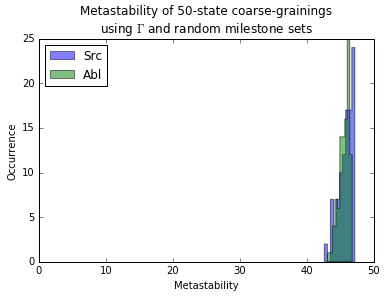

In [46]:
n_bins=10
plt.hist([np.trace(m.P) for m in ms_msms_src], bins=n_bins, alpha=0.5, histtype='stepfilled', label='Src')
plt.hist([np.trace(m.P) for m in ms_msms_abl], bins=n_bins, alpha=0.5, histtype='stepfilled', label='Abl')
plt.xlim(0, n_macrostates)
plt.legend(loc='best')
plt.title('Metastability of 50-state coarse-grainings\nusing $\Gamma$ and random milestone sets')
plt.xlabel('Metastability')
plt.ylabel('Occurrence')

In [50]:
np.max([np.trace(m.P) for m in ms_msms_src]), np.max([np.trace(m.P) for m in ms_msms_abl])

(47.174510509920779, 46.778106126080566)

In [26]:
# as a baseline, what's the metastability if we just do random coarse-graining?

cg_msms_src = []
cg_msms_abl = []

n_samples = 100
n_macrostates = 50

for _ in tqdm(range(n_samples)):

    cg_dtrajs = apply_coarse_graining(dtrajs_src, assignment = np.random.randint(0,n_macrostates,1000))
    cg_msms_src.append(estimate_msm(cg_dtrajs))
    
    cg_dtrajs = apply_coarse_graining(dtrajs_abl, assignment = np.random.randint(0,n_macrostates,1000))
    cg_msms_abl.append(estimate_msm(cg_dtrajs))

100%|██████████| 100/100 [04:35<00:00,  1.71s/it]


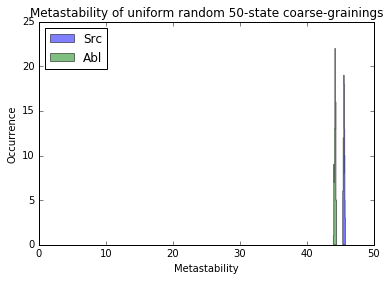

In [30]:
n_bins=10
plt.hist([np.trace(m.P) for m in cg_msms_src], bins=n_bins, alpha=0.5, histtype='stepfilled', label='Src')
plt.hist([np.trace(m.P) for m in cg_msms_abl], bins=n_bins, alpha=0.5, histtype='stepfilled', label='Abl')
plt.xlim(0, n_macrostates)
plt.legend(loc='best')
plt.title('Metastability of 50-state coarse-grainings\n using uniform random assignments')
plt.xlabel('Metastability')
plt.ylabel('Occurrence')

In [49]:
np.max([np.trace(m.P) for m in cg_msms_src]), np.max([np.trace(m.P) for m in cg_msms_abl])

(45.767088334349602, 44.441086516101208)

In [ ]:
plt.plot(gamma_src[0])
plt.title('Gamma[0,:]')
plt.figure()
plt.plot(gamma_src[5])
plt.figure()
plt.plot(gamma_src[10])
plt.figure()
plt.plot(gamma_src[100])

In [114]:
# what about just directly minimizing the metastability index?

# the metastability index is composed of a numerator and a denominator term
# we want the numerator to be small and the denominator to be 

def remove_worst_using_numerator(gamma, M):
    '''
    identifies i the worst trial microstate currently in M, and removes it
    
    M <-- M \ i
    
    where i is the element of M for which the probability
    is the highest that, after hitting i, the trajectory
    will hit some other target milestone j \in M before hitting i
    again
    '''
    M = list(M)
    i = np.argmax([max(gamma[i, np.array(list(set(M) - set([i])))]) for i in M])
    _ = M.pop(i)
    return set(M)

def add_best_using_denominator_term(gamma, M):
    '''
    identifies i the best trial microstate not currently in M, the denominator of metastability_index
    
    M <-- M + {i}
    '''
    l = list(set(range(len(gamma))) - set(M))
    i = np.argmin([max(gamma[i]) for i in l])
    
    return set(M).union(set([i]))

In [57]:
def form_gamma(dtrajs):
    dtraj_stack = np.hstack(dtrajs)
    n_states = len(set(dtraj_stack))
    
    gamma = np.zeros((n_states,n_states))
    
    for dtraj in tqdm(dtrajs):
        for i in range(n_states):
            indices = list(np.arange(len(dtraj))[dtraj==i]) + [len(dtraj)]
            for t in range(len(indices)-1):
                js = set(dtraj[indices[t]:indices[t+1]])
                for j in js - set([i]):
                    gamma[i,j] += 1
        
    for i in range(n_states):
        gamma[i] /= np.sum(dtraj_stack==i)
    
    return gamma

gamma_src_ = form_gamma(dtrajs_src)

100%|██████████| 482/482 [00:15<00:00, 14.70it/s]


In [89]:
def greedy_subtraction_optimizer(gamma, target_size = 10, callback=None):
    '''
    at each iteration, remove the "worst" milestone identified in the numerator of the metastability index
    '''
    M = set(range(len(gamma)))
    for _ in tqdm(range(len(M) - target_size)):
        M = remove_worst_using_numerator(gamma, M)
        if callback: callback(M)
    return M

# define callbacks to store intermediate results
Ms_src = []
metastability_indices_src = []

Ms_abl = []
metastability_indices_abl = []

def callback_src(M):
    Ms_src.append(M)
    metastability_indices_src.append(metastability_index(gamma_src, M))

def callback_abl(M):
    Ms_abl.append(M)
    metastability_indices_abl.append(metastability_index(gamma_abl, M))

M_src = greedy_subtraction_optimizer(gamma_src, callback=callback_src)

 84%|████████▍ | 833/990 [04:00<00:11, 13.38it/s]


ZeroDivisionError: integer division or modulo by zero

In [93]:
M_abl = greedy_subtraction_optimizer(gamma_abl, callback=callback_abl)

 87%|████████▋ | 865/990 [04:03<00:07, 16.16it/s]


ZeroDivisionError: integer division or modulo by zero

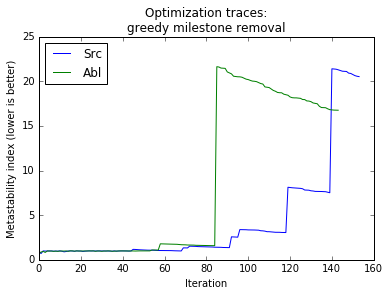

In [94]:
plt.plot(metastability_indices_src, label='Src')
plt.plot(metastability_indices_abl, label='Abl')

plt.title('Optimization traces:\ngreedy milestone removal')
plt.ylabel('Metastability index (lower is better)')
plt.xlabel('Iteration')
plt.legend(loc='best')

In [76]:
def milestone(dtrajs, milestoning_set):
    '''
    construct milestone-based trajectories
    '''
    milestoned_dtrajs = []
    for dtraj in dtrajs:
        milestoned_traj = np.zeros(len(dtraj),dtype=int)

        last_milestone_visited = -1
        for i in range(len(dtraj)):

            if dtraj[i] in milestoning_set:
                last_milestone_visited = dtraj[i]

            milestoned_traj[i] = last_milestone_visited
        milestoned_dtrajs.append(milestoned_traj+1)
    return milestoned_dtrajs

ms_dtrajs_src = milestone(dtrajs_src, Ms[-1])

In [78]:
len(Ms[-1])

165

In [79]:
msm = estimate_msm(ms_dtrajs_src)

In [81]:
msm.active_set

array([996])

In [82]:
np.trace(msm.P)

1.0

In [85]:
cg_dtrajs = apply_coarse_graining(dtrajs_src, assignment = assign_microstates_to_macrostates(gamma_src, Ms_src[-1]))
cg_msm_src = estimate_msm(cg_dtrajs)
np.trace(cg_msm_src.P)

148.48146194297863

In [86]:
len(cg_msm_src.P)

159

In [100]:
# and again, for abl
cg_dtrajs = apply_coarse_graining(dtrajs_abl, assignment = assign_microstates_to_macrostates(gamma_abl, Ms_abl[-1]))
cg_msm_abl = estimate_msm(cg_dtrajs)
np.trace(cg_msm_abl.P)

123.33128985982374

In [101]:
len(cg_msm_abl.P)

133

Plot coarse-grained free energies

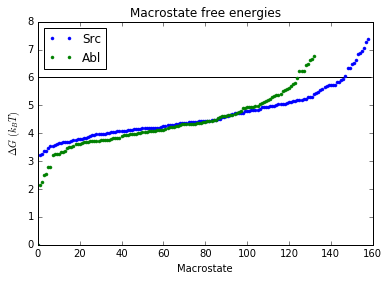

In [105]:
def plot_free_energies(msm, name = None):
    f_i = -np.log(sorted(msm.stationary_distribution))[::-1]
    f_i -= f_i.min()
    plt.plot(f_i,'.',label=name)
    plt.hlines(6,0,len(f_i))

plot_free_energies(cg_msm_src, name = 'Src')
plot_free_energies(cg_msm_abl, name = 'Abl')
plt.legend(loc='best')
plt.xlabel('Macrostate')
plt.ylabel(r'$\Delta G$ $(k_B T)$')
plt.title('Macrostate free energies')

In [129]:
# greedy addition optimizer

def greedy_addition_optimizer(gamma, init_M, target_size = 150, callback=None):
    '''
    at each iteration, add the "best" trial milestone identified in the denominator of the metastability index
    '''
    M = init_M
    for _ in tqdm(range(target_size - len(init_M))):
        M = add_best_using_denominator_term(gamma, M)
        if callback: callback(M)
    return M

Ms_src = []
metastability_indices_src = []

Ms_abl = []
metastability_indices_abl = []

def callback_src(M):
    Ms_src.append(M)
    metastability_indices_src.append(metastability_index(gamma_src, M))

def callback_abl(M):
    Ms_abl.append(M)
    metastability_indices_abl.append(metastability_index(gamma_abl, M))

np.random.seed(0)
init_M = set(np.random.randint(0,1000,20))

M_src = greedy_addition_optimizer(gamma_src, init_M, callback=callback_src)
M_abl = greedy_addition_optimizer(gamma_abl, init_M, callback=callback_abl)

100%|██████████| 130/130 [00:16<00:00,  6.95it/s]


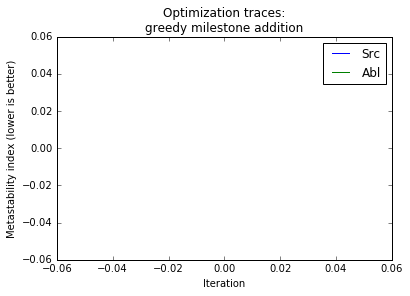

In [130]:
plt.plot(metastability_indices_src, label='Src')
plt.plot(metastability_indices_abl, label='Abl')

plt.title('Optimization traces:\ngreedy milestone addition')
plt.ylabel('Metastability index (lower is better)')
plt.xlabel('Iteration')
plt.legend(loc='best')

In [132]:
cg_dtrajs = apply_coarse_graining(dtrajs_src, assignment = assign_microstates_to_macrostates(gamma_src, M_src))
cg_msm_src = estimate_msm(cg_dtrajs)
np.trace(cg_msm_src.P)

22.769094968513535

In [137]:
cg_msm_src.active_state_fraction

1.0

In [135]:
len(cg_msm_src.P)

25

In [133]:
# and again, for abl
cg_dtrajs = apply_coarse_graining(dtrajs_abl, assignment = assign_microstates_to_macrostates(gamma_abl, M_abl))
cg_msm_abl = estimate_msm(cg_dtrajs)
np.trace(cg_msm_abl.P)

89.526895235050944

In [136]:
len(cg_msm_abl.P)

96

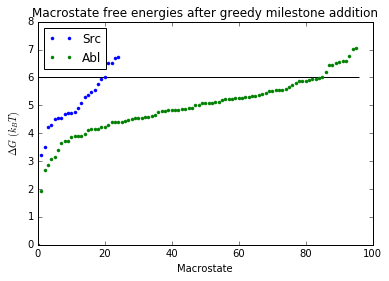

In [134]:
plot_free_energies(cg_msm_src, name = 'Src')
plot_free_energies(cg_msm_abl, name = 'Abl')
plt.legend(loc='best')
plt.xlabel('Macrostate')
plt.ylabel(r'$\Delta G$ $(k_B T)$')
plt.title('Macrostate free energies after greedy milestone addition')